<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Objectif-:" data-toc-modified-id="Objectif-:-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Objectif :</a></span></li><li><span><a href="#Dev" data-toc-modified-id="Dev-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dev</a></span></li><li><span><a href="#Industrialisation" data-toc-modified-id="Industrialisation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Industrialisation</a></span><ul class="toc-item"><li><span><a href="#Script" data-toc-modified-id="Script-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Script</a></span></li></ul></li><li><span><a href="#Analyse-de-la-feature" data-toc-modified-id="Analyse-de-la-feature-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Analyse de la feature</a></span><ul class="toc-item"><li><span><a href="#Analyse-des-dépot-suivant-les-stations" data-toc-modified-id="Analyse-des-dépot-suivant-les-stations-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Analyse des dépot suivant les stations</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd
import polars as pl
import seaborn as sns

from vcub_keeper.reader.reader import read_activity_vcub
from vcub_keeper.visualisation import plot_station_activity

sns.set_style("whitegrid")
%matplotlib inline

%load_ext autoreload
%autoreload 2

## Objectif :

- Création d'une features afin de connaitre le nombre d'ajout de vélo qu'il y a eu pour une même station entre 2 points temporels. cf https://github.com/armgilles/vcub_keeper/issues/4 et https://github.com/armgilles/vcub_keeper/issues/121
- Industrialisation de la fonction
- Analyse des résultats

## Dev

In [2]:
# Lecture de l'activité des stations
activite = read_activity_vcub()

In [4]:
activite.head()

In [5]:
activite.collect_schema().dtypes()

[UInt8,
 UInt8,
 Categorical(ordering='physical'),
 String,
 String,
 Int8,
 Int8,
 Datetime(time_unit='us', time_zone=None)]

In [6]:
available_bikes_shift = pl.col("available_bikes").shift(1).over("station_id").fill_null(pl.col("available_bikes"))
transactions_in = pl.col("available_bikes") - available_bikes_shift

activite.with_columns(pl.when(transactions_in < 0).then(0).otherwise(transactions_in).alias("transactions_in"))

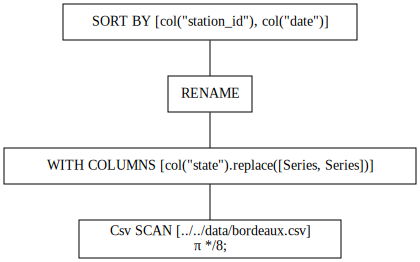

In [7]:
activite.show_graph()

In [8]:
activite.collect().head()

gid,station_id,type,name,state,available_stands,available_bikes,date
u8,u8,cat,str,str,i8,i8,datetime[μs]
83,1,"""VLS""","""Meriadeck""","""1""",18,2,2017-07-09 00:03:04
83,1,"""VLS""","""Meriadeck""","""1""",18,2,2017-07-09 00:04:04
83,1,"""VLS""","""Meriadeck""","""1""",18,2,2017-07-09 00:09:04
83,1,"""VLS""","""Meriadeck""","""1""",18,2,2017-07-09 00:14:03
83,1,"""VLS""","""Meriadeck""","""1""",18,2,2017-07-09 00:19:04


## Industrialisation

In [11]:
from vcub_keeper.transform.features_factory import get_transactions_in

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# Lecture de l'activité des stations
activite = read_activity_vcub()

activite.with_columns(get_transactions_in())

In [13]:
%%timeit -r 10
activite = read_activity_vcub()
activite.with_columns(get_transactions_in()).collect()

775 ms ± 13.7 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [14]:
activite = activite.with_columns(get_transactions_in()).collect()

In [16]:
activite.slice(136025, 20)

gid,station_id,type,name,state,available_stands,available_bikes,date,transactions_in
u8,u8,cat,str,str,i8,i8,datetime[μs],i8
86,7,"""VLS""","""Palais de Justice""","""1""",16,2,2017-08-02 10:55:03,0
86,7,"""VLS""","""Palais de Justice""","""1""",16,2,2017-08-02 11:00:03,0
86,7,"""VLS""","""Palais de Justice""","""1""",16,2,2017-08-02 11:05:04,0
86,7,"""VLS""","""Palais de Justice""","""1""",16,2,2017-08-02 11:10:04,0
86,7,"""VLS""","""Palais de Justice""","""1""",17,1,2017-08-02 11:15:03,0
…,…,…,…,…,…,…,…,…
86,7,"""VLS""","""Palais de Justice""","""1""",17,1,2017-08-02 12:25:04,0
86,7,"""VLS""","""Palais de Justice""","""1""",12,6,2017-08-02 12:40:06,5
86,7,"""VLS""","""Palais de Justice""","""1""",14,4,2017-08-02 12:45:03,0


### Script

In [17]:
from vcub_keeper.reader.reader import read_activity_vcub
from vcub_keeper.transform.features_factory import get_transactions_in

In [18]:
# Lecture de l'activité des stations
activite = read_activity_vcub()

activite = activite.with_columns(get_transactions_in()).collect()

In [19]:
activite.slice(436030, 15)

gid,station_id,type,name,state,available_stands,available_bikes,date,transactions_in
u8,u8,cat,str,str,i8,i8,datetime[μs],i8
91,21,"""VLS""","""Puy Paulin""","""1""",14,1,2017-07-22 08:50:03,0
91,21,"""VLS""","""Puy Paulin""","""1""",14,1,2017-07-22 08:55:04,0
91,21,"""VLS""","""Puy Paulin""","""1""",14,1,2017-07-22 09:00:03,0
91,21,"""VLS""","""Puy Paulin""","""1""",12,3,2017-07-22 09:05:04,2
91,21,"""VLS""","""Puy Paulin""","""1""",12,3,2017-07-22 09:10:04,0
…,…,…,…,…,…,…,…,…
91,21,"""VLS""","""Puy Paulin""","""1""",7,8,2017-07-22 09:45:04,2
91,21,"""VLS""","""Puy Paulin""","""1""",7,8,2017-07-22 09:50:03,0
91,21,"""VLS""","""Puy Paulin""","""1""",5,10,2017-07-22 09:55:04,2


## Analyse de la feature

In [20]:
# Lecture de l'activité des stations
activite = read_activity_vcub()

activite = activite.with_columns(get_transactions_in()).collect()

In [22]:
activite.select(pl.col("transactions_in")).describe()

statistic,transactions_in
str,f64
"""count""",3.76188e6
"""null_count""",0.0
"""mean""",0.128022
"""std""",0.508419
"""min""",0.0
"""25%""",0.0
"""50%""",0.0
"""75%""",0.0
"""max""",34.0


<Axes: >

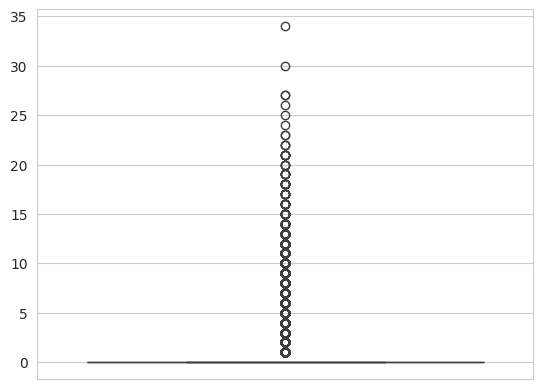

In [23]:
sns.boxplot(activite["transactions_in"])

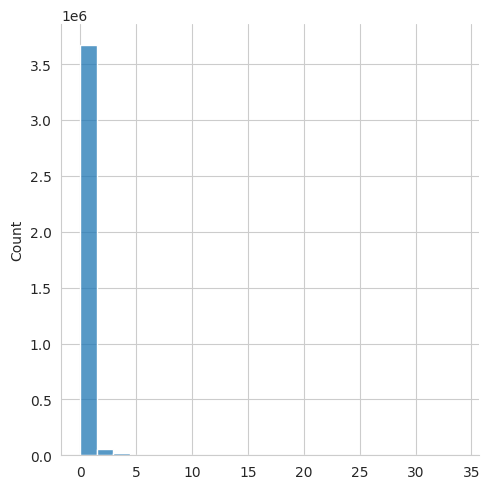

In [24]:
sns.displot(activite["transactions_in"])

### Analyse des dépot suivant les stations [OLD]

In [48]:
ajout_by_station = activite.group_by("station_id").agg(
    [
        pl.col("transactions_in").max().alias("max"),
        pl.col("transactions_in").mean().alias("mean"),
        pl.col("transactions_in").median().alias("median"),
        pl.col("transactions_in").min().alias("min"),
        pl.col("transactions_in").std().alias("std"),
        pl.col("transactions_in").var().alias("var"),
        pl.col("transactions_in").skew().alias("skew"),
        pl.col("transactions_in").quantile(0.25).alias("25%"),
        pl.col("transactions_in").quantile(0.75).alias("75%"),
        pl.col("transactions_in").quantile(0.95).alias("95%"),
    ]
)

ajout_by_station = ajout_by_station.sort("mean", descending=True)

In [49]:
ajout_by_station

station_id,max,mean,median,min,std,var,skew,25%,75%,95%
u8,i8,f64,f64,i8,f64,f64,f64,f64,f64,f64
106,21,0.565402,0.0,0,1.436742,2.064227,4.79362,0.0,1.0,3.0
5,34,0.447965,0.0,0,1.12362,1.262522,6.358396,0.0,0.0,2.0
22,20,0.433349,0.0,0,0.967461,0.93598,3.589955,0.0,0.0,2.0
123,22,0.41716,0.0,0,1.265391,1.601213,6.216795,0.0,0.0,2.0
39,25,0.416512,0.0,0,1.089252,1.18647,5.404193,0.0,0.0,2.0
…,…,…,…,…,…,…,…,…,…,…
160,3,0.001156,0.0,0,0.041354,0.00171,43.739809,0.0,0.0,0.0
76,1,0.000046,0.0,0,0.006801,0.000046,147.027209,0.0,0.0,0.0
35,0,0.0,0.0,0,0.0,0.0,NaN,0.0,0.0,0.0


In [ ]:
# Station les plus active sur les dépôt de vélo
plot_station_activity(activite.to_pandas(), station_id=106, features_to_plot=["transactions_in"])

In [ ]:
activite.tail()

In [53]:
plot_station_activity(
    activite.to_pandas(),
    station_id=5,
    features_to_plot=["available_bikes"],
    start_date="2017-08-22",
    end_date="2017-08-30",
)

# Test

In [23]:
from vcub_keeper.reader.reader import read_activity_vcub
from vcub_keeper.transform.features_factory import get_transactions_in

In [28]:
# Lecture de l'activité des stations
activite = read_activity_vcub()

In [29]:
activite = get_transactions_in(activite)

In [30]:
activite["date"].min()

Timestamp('2017-07-09 00:03:04')

In [32]:
activite[activite["transactions_in"] > 0].head(15)

,gid,station_id,type,name,state,available_stands,available_bikes,date,transactions_in
41,83,1,VLS,Meriadeck,1,19,1,2017-07-09 03:24:05,1.0
43,83,1,VLS,Meriadeck,1,18,2,2017-07-09 03:34:04,1.0
46,83,1,VLS,Meriadeck,1,16,4,2017-07-09 03:49:03,2.0
57,83,1,VLS,Meriadeck,1,16,4,2017-07-09 04:44:04,1.0
58,83,1,VLS,Meriadeck,1,15,5,2017-07-09 04:49:04,1.0
60,83,1,VLS,Meriadeck,1,14,6,2017-07-09 04:59:05,1.0
69,83,1,VLS,Meriadeck,1,13,7,2017-07-09 05:44:04,1.0
77,83,1,VLS,Meriadeck,1,12,8,2017-07-09 06:24:05,1.0
82,83,1,VLS,Meriadeck,1,12,8,2017-07-09 06:49:04,1.0
102,83,1,VLS,Meriadeck,1,13,7,2017-07-09 08:29:04,1.0


In [43]:
# activite[(activite["transactions_out"] > 1) & (activite["date"] == "2017-07-09 11:09:04")].head()
# activite[(activite["date"] >= "'2017-07-09 03:24:05'") & (activite["station_id"] == 1)].head(11).to_dict(orient="list")
activite[(activite["date"] >= "2017-07-09 00:54:05") & (activite["station_id"] == 22)].head(11).to_dict(orient="list")

{'gid': [92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92],
 'station_id': [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22],
 'type': ['VLS',
  'VLS',
  'VLS',
  'VLS',
  'VLS',
  'VLS',
  'VLS',
  'VLS',
  'VLS',
  'VLS',
  'VLS'],
 'name': ['Hotel de Ville',
  'Hotel de Ville',
  'Hotel de Ville',
  'Hotel de Ville',
  'Hotel de Ville',
  'Hotel de Ville',
  'Hotel de Ville',
  'Hotel de Ville',
  'Hotel de Ville',
  'Hotel de Ville',
  'Hotel de Ville'],
 'state': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'available_stands': [33, 33, 31, 33, 33, 33, 33, 32, 33, 33, 33],
 'available_bikes': [0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0],
 'date': [Timestamp('2017-07-09 00:54:05'),
  Timestamp('2017-07-09 00:59:04'),
  Timestamp('2017-07-09 01:04:04'),
  Timestamp('2017-07-09 01:09:03'),
  Timestamp('2017-07-09 01:14:04'),
  Timestamp('2017-07-09 01:19:04'),
  Timestamp('2017-07-09 01:24:04'),
  Timestamp('2017-07-09 01:29:04'),
  Timestamp('2017-07-09 01:34:04'),
  Timestamp('2017-07-09 01:39:04'),
  Timestamp('

In [ ]:
{
    "gid": [92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92],
    "station_id": [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22],
    "type": ["VLS", "VLS", "VLS", "VLS", "VLS", "VLS", "VLS", "VLS", "VLS", "VLS", "VLS"],
    "name": [
        "Hotel de Ville",
        "Hotel de Ville",
        "Hotel de Ville",
        "Hotel de Ville",
        "Hotel de Ville",
        "Hotel de Ville",
        "Hotel de Ville",
        "Hotel de Ville",
        "Hotel de Ville",
        "Hotel de Ville",
        "Hotel de Ville",
    ],
    "state": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    "available_stands": [33, 33, 31, 33, 33, 33, 33, 32, 33, 33, 33],
    "available_bikes": [0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0],
    "date": [
        pd.Timestamp("2017-07-09 00:54:05"),
        pd.Timestamp("2017-07-09 00:59:04"),
        pd.Timestamp("2017-07-09 01:04:04"),
        pd.Timestamp("2017-07-09 01:09:03"),
        pd.Timestamp("2017-07-09 01:14:04"),
        pd.Timestamp("2017-07-09 01:19:04"),
        pd.Timestamp("2017-07-09 01:24:04"),
        pd.Timestamp("2017-07-09 01:29:04"),
        pd.Timestamp("2017-07-09 01:34:04"),
        pd.Timestamp("2017-07-09 01:39:04"),
        pd.Timestamp("2017-07-09 01:44:05"),
    ],
    "transactions_in": [0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
}

In [46]:
data = {
    "gid": [83] * 11 + [92] * 11,
    "station_id": [1] * 11 + [22] * 11,
    "type": ["VLS"] * 11 + ["VLS"] * 11,
    "name": ["Meriadeck"] * 11 + ["Hotel de Ville"] * 11,
    "state": [1] * 11 + [1] * 11,
    "available_stands": [19, 19, 18, 18, 18, 16, 16, 16, 16, 17, 17] + [33, 33, 31, 33, 33, 33, 33, 32, 33, 33, 33],
    "available_bikes": [1, 1, 2, 2, 2, 4, 4, 4, 4, 3, 3] + [0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0],
    "date": [
        pd.Timestamp("2017-07-09 03:24:05"),
        pd.Timestamp("2017-07-09 03:29:04"),
        pd.Timestamp("2017-07-09 03:34:04"),
        pd.Timestamp("2017-07-09 03:39:04"),
        pd.Timestamp("2017-07-09 03:44:05"),
        pd.Timestamp("2017-07-09 03:49:03"),
        pd.Timestamp("2017-07-09 03:54:04"),
        pd.Timestamp("2017-07-09 03:59:03"),
        pd.Timestamp("2017-07-09 04:04:06"),
        pd.Timestamp("2017-07-09 04:09:04"),
        pd.Timestamp("2017-07-09 04:14:04"),
    ]
    + [
        pd.Timestamp("2017-07-09 00:54:05"),
        pd.Timestamp("2017-07-09 00:59:04"),
        pd.Timestamp("2017-07-09 01:04:04"),
        pd.Timestamp("2017-07-09 01:09:03"),
        pd.Timestamp("2017-07-09 01:14:04"),
        pd.Timestamp("2017-07-09 01:19:04"),
        pd.Timestamp("2017-07-09 01:24:04"),
        pd.Timestamp("2017-07-09 01:29:04"),
        pd.Timestamp("2017-07-09 01:34:04"),
        pd.Timestamp("2017-07-09 01:39:04"),
        pd.Timestamp("2017-07-09 01:44:05"),
    ],
    "transactions_in": [0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    + [0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
}

df_activite = pd.DataFrame(data)
# drop columns we want to test.
df_activite = df_activite.drop(columns=["transactions_in"], axis=1)

result = get_transactions_in(df_activite)

expected = pd.DataFrame(data)

pd.testing.assert_frame_equal(result, expected)